## ランダムフォレストで決定木を描画する

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#下記は決定木可視化のためのツール
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

from dtreeviz.trees import dtreeviz

import pydot
import cv2

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [4]:
df['Embarked'].value_counts().index[0]

'S'

In [5]:
data = df.copy()

In [6]:
data['Sex'] = data['Sex'].map({'male':0, 'female':1})
# 正規分布に従う確率変数で列：Ageを補完
rv = np.random.normal(loc=data['Age'].mean(), scale=data['Age'].std(), size=data['Age'].isnull().sum())
rv = np.copysign(rv, 1) # 負の値は符号を反転させる
rv_s = pd.Series(rv, index=data[data['Age'].isnull()].index)
data['Age'] = data['Age'].fillna(rv_s)
# 列：Embarkedは最頻値で補完
data['Embarked'] = data['Embarked'].fillna(df['Embarked'].value_counts().index[0])
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


In [8]:
data.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.024715,-0.057527,-0.001652,0.012658,-0.030467
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.032350,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.317803,0.083081,0.018443,-0.549500,0.045702
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.055139,0.114631,0.245489,0.182333,0.116569
Age,0.024715,-0.032350,-0.317803,-0.055139,1.000000,-0.201231,-0.165378,0.082091,0.017214
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.201231,1.000000,0.414838,0.159651,-0.059961
Parch,-0.001652,0.081629,0.018443,0.245489,-0.165378,0.414838,1.000000,0.216225,-0.078665
Fare,0.012658,0.257307,-0.549500,0.182333,0.082091,0.159651,0.216225,1.000000,0.062142
Embarked,-0.030467,0.106811,0.045702,0.116569,0.017214,-0.059961,-0.078665,0.062142,1.000000


### データセットを作成

In [9]:
data2 = data.copy()[['Pclass','Sex','Fare', 'Embarked']]
label = data.copy()['Survived']

In [10]:
train_d, test_d, train_l, test_l = train_test_split(data2, label, test_size=0.3, random_state=0)

In [11]:
#train_d1, train_d2, train_l1, train_l2 = train_test_split(train_d, train_l, test_size=0.3)

In [12]:
clf1 = SVC()
clf2 = RFC()
clf1.fit(train_d, train_l)
clf2.fit(train_d, train_l)
svm_score = clf1.score(test_d, test_l)
rfc_score = clf2.score(test_d, test_l)
print("[Default parameter]")
print(f"SVM: {svm_score*100:.3f}%\nRFC: {rfc_score*100:.3f}%")

[Default parameter]
SVM: 70.522%
RFC: 81.343%


正解率以外の尺度で評価してみる

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
prd_svm = clf1.predict(test_d)
prd_rfc = clf2.predict(test_d)

precision_s = precision_score(prd_svm, test_l)
precision_r = precision_score(prd_rfc, test_l)
recall_s = recall_score(prd_svm, test_l)
recall_r = recall_score(prd_rfc, test_l)
f1_s = f1_score(prd_svm, test_l)
f1_r = f1_score(prd_rfc, test_l)

print("精度")
print(f"SVM: {precision_s:.3f}\nRFC: {precision_r:.3f}")
print("再現率")
print(f"SVM: {recall_s:.3f}\nRFC: {recall_r:.3f}")
print("F値")
print(f"SVM: {f1_s:.3f}\nRFC: {f1_r:.3f}")


精度
SVM: 0.290
RFC: 0.730
再現率
SVM: 0.784
RFC: 0.760
F値
SVM: 0.423
RFC: 0.745


### モデル可視化

ソース元  
https://qiita.com/go50/items/38c7757b444db3867b17

In [22]:
print(clf2.classes_)

[0 1]


In [23]:
data2.columns

Index(['Pclass', 'Sex', 'Fare', 'Embarked'], dtype='object')

In [25]:
estimators = clf2.estimators_
viz = dtreeviz(
    estimators[0],
    data2, 
    label,
    target_name='survived',
    feature_names=data2.columns,
    class_names=['0', '1'],
) 

viz.save("estimator1.svg")

### モデル可視化 2

ソース元  
https://teratail.com/questions/145778

In [26]:
# 1つ目の分類木から dot 形式の文字列を作成する。
est = clf2.estimators_[0]
dot_str = export_graphviz(
    est,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=data2.columns,
    class_names=["0", "1"])

# dot 形式の文字列から pydot オブジェクトを作成する。
graphs = pydot.graph_from_dot_data(dot_str)
# pydot オブジェクトから png 形式の画像を作成する。
png_data = graphs[0].create_png(prog='dot')

f = open("estimator1.png", "wb")
f.write(png_data)
f.close()
# IPython に表示する。
#display.display(display.Image(png_data))


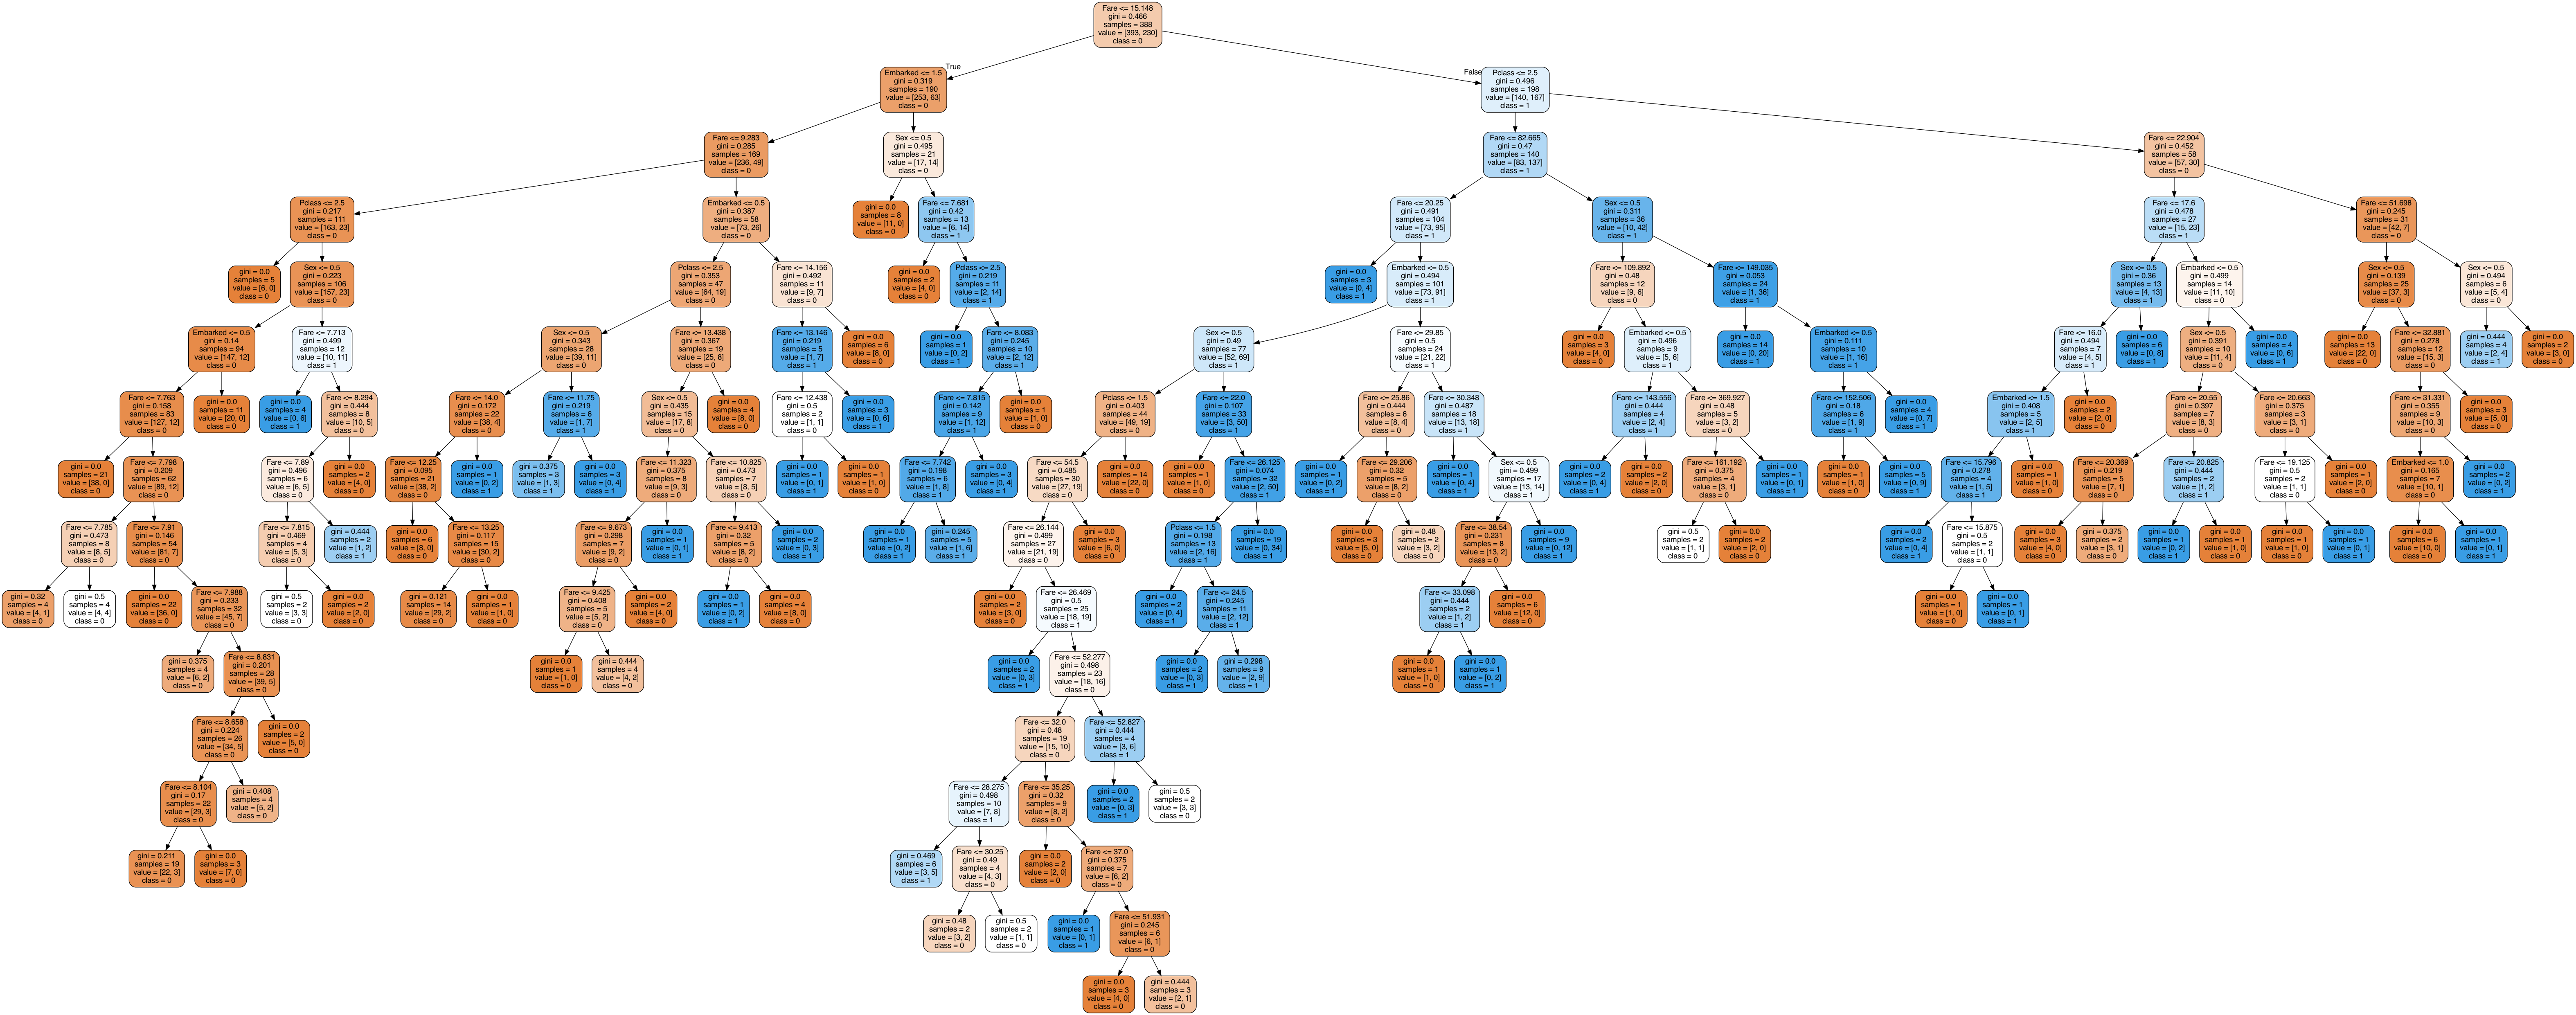

In [29]:
from IPython.display import display, Image
display(Image(png_data))

In [35]:
f_importance = clf2.feature_importances_

In [36]:
from matplotlib import pyplot as plt

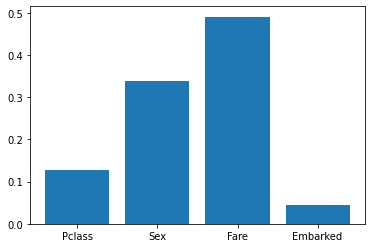

In [37]:
plt.ylim = (0, 1)
x = np.arange(len(f_importance))
height = f_importance
plt.bar(x, height, align='center')
plt.xticks(ticks=x, labels=data2.columns)
plt.show()

特徴量から"Fare"を外してみる

In [49]:
data3 = data.copy()[['Pclass','Sex','Embarked']]
train_d2, test_d2, train_l2, test_l2 = train_test_split(data3, label, test_size=0.3, random_state=0)
clf3 = SVC()
clf4 = RFC()
clf3.fit(train_d2, train_l2)
clf4.fit(train_d2, train_l2)
svm_score = clf3.score(test_d2, test_l2)
rfc_score = clf4.score(test_d2, test_l2)
print("[Default parameter]")
print(f"SVM: {svm_score*100:.3f}%\nRFC: {rfc_score*100:.3f}%")

[Default parameter]
SVM: 80.970%
RFC: 80.970%


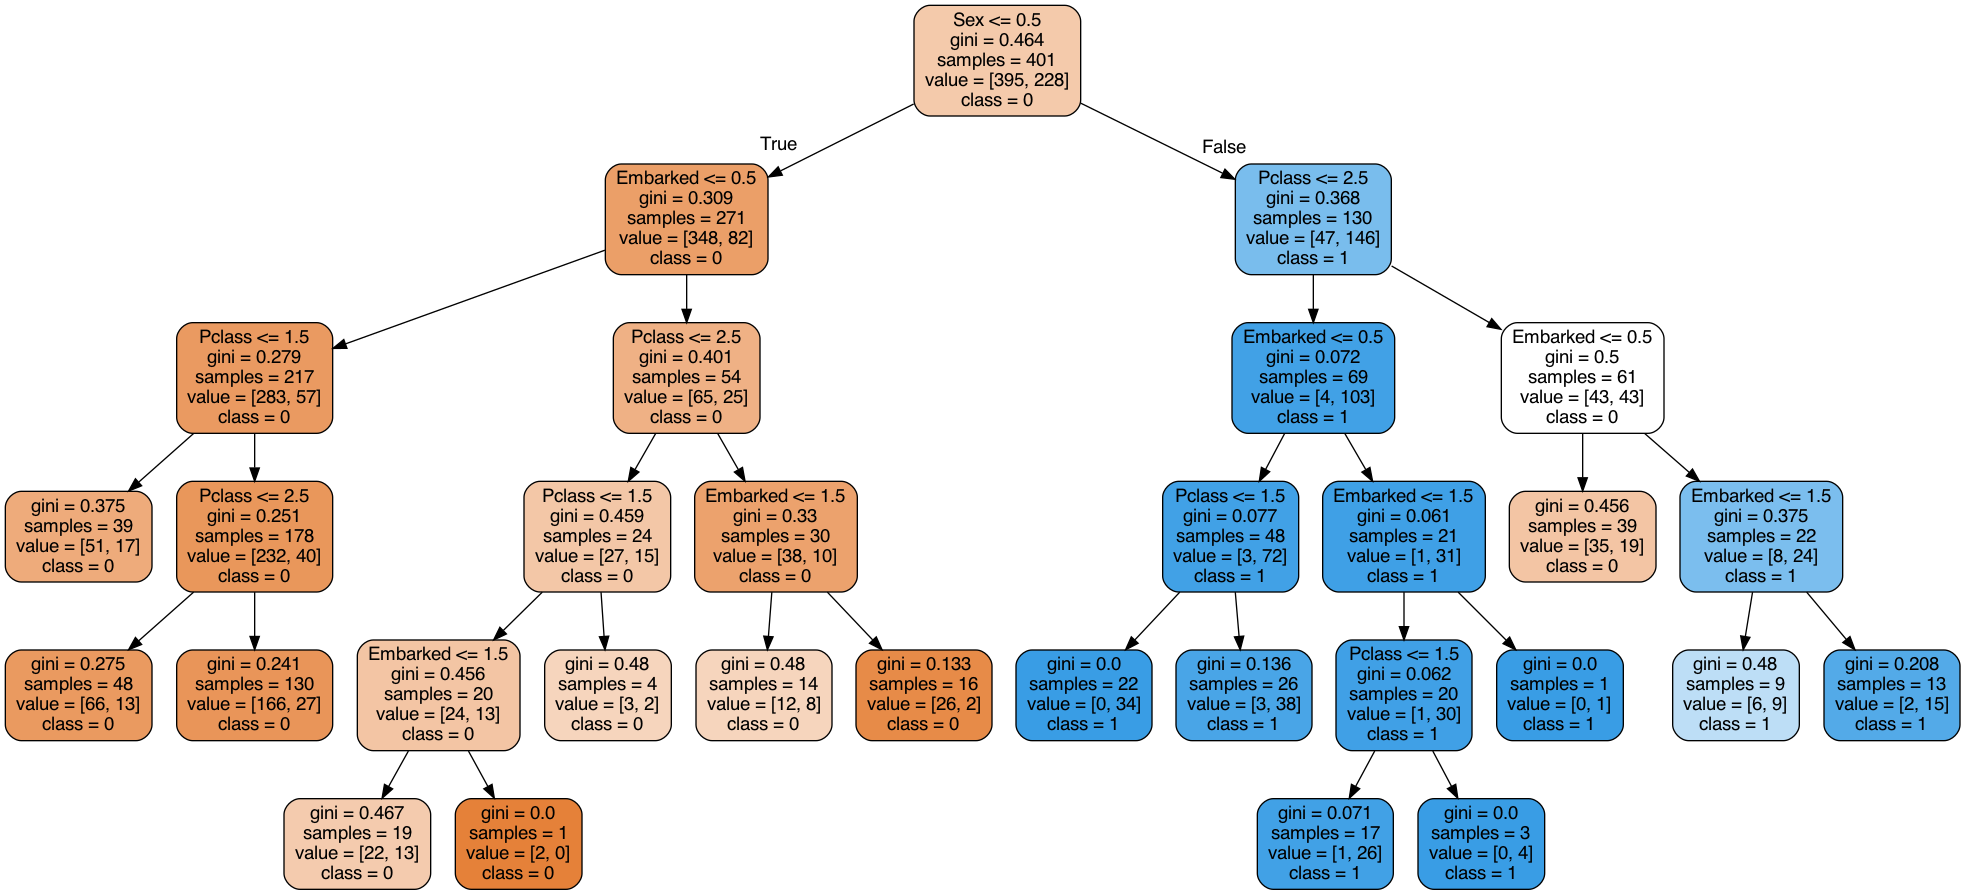

In [50]:
# 1つ目の分類木から dot 形式の文字列を作成する。
est = clf4.estimators_[0]
dot_str = export_graphviz(
    est,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=data3.columns,
    class_names=["0", "1"])

# dot 形式の文字列から pydot オブジェクトを作成する。
graphs = pydot.graph_from_dot_data(dot_str)
# pydot オブジェクトから png 形式の画像を作成する。
png_data = graphs[0].create_png(prog='dot')

#f = open("estimator1.png", "wb")
#f.write(png_data)
#f.close()

display(Image(png_data))

### wineデータセットによる検証

In [2]:
df_wine = pd.read_csv('wine.csv')
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  label

In [5]:
data_wine = df_wine.drop('label', axis=1)
label = df_wine['label']

In [14]:
data_wine0 = data_wine[label == 0]
label0 = label[label == 0]
data_wine12 = data_wine[label != 0]
label12 = label[label != 0]

In [11]:
data_wine0.count()

alcohol                         59
malic_acid                      59
ash                             59
alcalinity_of_ash               59
magnesium                       59
total_phenols                   59
flavanoids                      59
nonflavanoid_phenols            59
proanthocyanins                 59
color_intensity                 59
hue                             59
od280/od315_of_diluted_wines    59
proline                         59
dtype: int64

In [13]:
label0.count()

59

In [15]:
label12.count()

119

In [17]:
data_wine12.count()

alcohol                         119
malic_acid                      119
ash                             119
alcalinity_of_ash               119
magnesium                       119
total_phenols                   119
flavanoids                      119
nonflavanoid_phenols            119
proanthocyanins                 119
color_intensity                 119
hue                             119
od280/od315_of_diluted_wines    119
proline                         119
dtype: int64

In [20]:
clf_wine = RFC()
clf_wine.fit(data_wine0, label0)
score = clf_wine.score(data_wine12, label12)
print('Score: ',score)

Score:  0.0


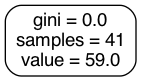

In [21]:
# 1つ目の分類木から dot 形式の文字列を作成する。
est = clf_wine.estimators_[0]
dot_str = export_graphviz(
    est,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=data_wine.columns,
    class_names=["0"])

# dot 形式の文字列から pydot オブジェクトを作成する。
graphs = pydot.graph_from_dot_data(dot_str)
# pydot オブジェクトから png 形式の画像を作成する。
png_data = graphs[0].create_png(prog='dot')

#f = open("estimator1.png", "wb")
#f.write(png_data)
#f.close()

display(Image(png_data))

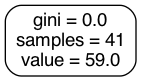

In [22]:
# 1つ目の分類木から dot 形式の文字列を作成する。
est = clf_wine.estimators_[0]
dot_str = export_graphviz(
    est,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=data_wine.columns,
    class_names=["0","1","2"])

# dot 形式の文字列から pydot オブジェクトを作成する。
graphs = pydot.graph_from_dot_data(dot_str)
# pydot オブジェクトから png 形式の画像を作成する。
png_data = graphs[0].create_png(prog='dot')

#f = open("estimator1.png", "wb")
#f.write(png_data)
#f.close()

display(Image(png_data))